In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
#Create an engine for the `hawaii.sqlite' database
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#Use the Inspector to explore the databases and print the table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#Use Inspector to print the columns names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
#Use Inspector to print the columns names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
#Find the latest date point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_date)

('2017-08-23',)


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", one_year_ago)

Query Date:  2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()
print(year_precip)

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 

In [17]:
# Save the query results as a Pandas DataFrame and 
precip_data = pd.DataFrame(year_precip, columns=['Date', 'Precipitation'])

#Set the index to the date column
precip_data.set_index('Date', inplace=True)

# Sort the dataframe by date
precip_data = precip_data.sort_values(by ='Date')
precip_data

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


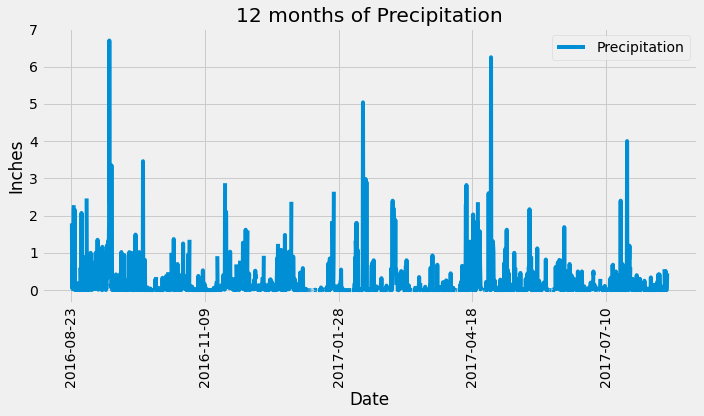

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_data.plot(title="12 months of Precipitation", figsize=(10,6), rot=90)

plt.ylabel("Inches")
plt.legend(loc='best')
plt.savefig("12_months_of_Precipitation.png")

#Tight layout and show graph
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_data.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(func.count(Station.station)).all()
print(total_stations)

[(9,)]


In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]

temperatures = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
temperatures

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772)]

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs = session.query(Measurement.tobs).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.station == "USC00519281").\
    order_by(Measurement.date).all()

# Save the Query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs, columns=["tobs"])

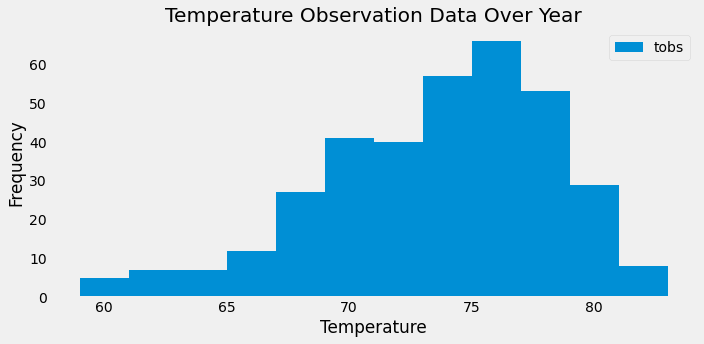

In [25]:
#Plot the results as a histogram with bins=12
tobs_df.plot.hist(bins=12, title="Temperature Observation Data Over Year", figsize=(10,5))

# Set labels
plt.xlabel("Temperature")
plt.ylabel("Frequency")
        
plt.grid()
plt.tight_layout()
           
# Save graph
plt.savefig("Temperature Observation Data Over Year.png") 
           
#Show graph
plt.show()